In [ ]:
%reload_ext autoreload
%autoreload 2

2024-12-03 20:46:54.802274: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 20:46:54.830042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 20:46:54.830074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 20:46:54.831496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 20:46:54.836875: I tensorflow/core/platform/cpu_feature_guar

1440
180
180
Found 1440 images belonging to 9 classes.
Found 180 images belonging to 9 classes.
Found 180 images belonging to 9 classes.


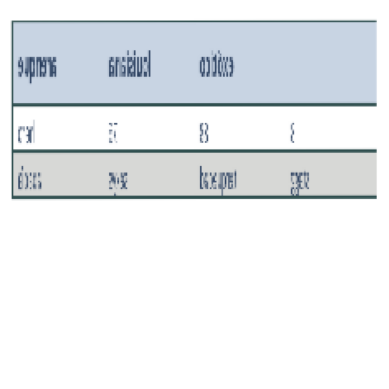

In [1]:
%run "../red_tables/data/0.1-drac-make_dataset.ipynb"
import red_tables.utils.paths as path
import tensorflow as tf
import time
import numpy as np

In [2]:
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

GPUs available: 1


2024-12-03 20:46:57.599652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 20:46:57.624899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 20:46:57.627721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten, BatchNormalization
from keras.optimizers import RMSprop, SGD, Adam
from keras import regularizers
from keras.regularizers import l1_l2
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import mlflow.keras

In [4]:
import mlflow
import dagshub

In [29]:
params = {
    'learning_rate' : 0.0125,
    'epochs' : 500,
    'batch_size' : 32,
    'beta_1' : 0.9286,
    'beta_2' : 0.9935,
    'epsilon': 1e-7,
    'lambda1' : 0.06,
    'lambda2': 0.06,
    'porcentaje':0.30,
    'optimizer':'Adam',
    'loss':'categorical_crossentropy'
}

In [6]:
epoch_steps = 1440 // params['batch_size']
test_steps = 180 // params['batch_size']

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

IMG_SIZE = 224  


In [8]:
#Cargamos MobileNetV2 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

#Congelamos capas
base_model.trainable = False

2024-12-03 20:46:58.116862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 20:46:58.119586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 20:46:58.122590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [35]:
# Añadir capas personalizadas
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = preprocess_input(inputs)  
x = base_model(x, training=False)  
x = GlobalAveragePooling2D()(x)  
#x = Dropout(0.2)(x) 
outputs = Dense(9, activation='softmax')(x)  

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [10]:
#def block(x,base_filter=16):
#  x = layers.Conv2D(base_filter,
#                    (3,3),
#                    activation="relu")(x)
#  x = layers.BatchNormalization()(x)
#  x = layers.MaxPooling2D(2)(x)
#  return x
#
#kernel_regularizer = l1_l2(params['lambda1'],params['lambda2'])
#
#inputs = keras.Input(shape=(200, 320, 1))
#x = inputs
#
#x = block(x,base_filter=32)
#x = block(x,base_filter=64)
#x = block(x, base_filter=128)
#
#x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(params['porcentaje'])(x)
#x = layers.Flatten()(x)
#
#x = layers.Dense(200, activation = 'relu',kernel_regularizer=kernel_regularizer)(x)
#x = layers.Dropout(params['porcentaje'])(x)
#x = layers.Dense(100, activation = 'relu')(x)
#x = layers.Dropout(params['porcentaje'])(x)
#x = layers.Dense(50, activation = 'relu',kernel_regularizer=kernel_regularizer)(x)
#outputs = layers.Dense(9, activation="softmax")(x)
#model = keras.Model(inputs=inputs, outputs=outputs)
#
#model.summary()

In [36]:
name_model = f'model_TRN__epochs={params["epochs"]}_lr={params["learning_rate"]}_%={params["porcentaje"]}.hdf5'
path_models = path.models_dir(name_model)

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [42]:
dagshub.init(repo_owner='DRACDARKTIME', repo_name='table_recognition_network', mlflow=True)
mlflow.set_experiment("model_TRN")
checkpoint = ModelCheckpoint(str(path_models), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          mode='max',
                          restore_best_weights=True,
                          patience=200,verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=15,
    min_lr=1e-6,
    verbose=1
)
mlflow.tensorflow.autolog()

Initialized MLflow to track repo "DRACDARKTIME/table_recognition_network"

Repository DRACDARKTIME/table_recognition_network initialized!

In [38]:
from tensorflow.keras import backend as K
import gc

K.clear_session()
gc.collect()

6736

In [44]:
mlflow.start_run()

model.compile(loss=params['loss'],
              optimizer=Adam(
                  learning_rate=params['learning_rate'],
                  beta_1=params['beta_1'],
                  beta_2=params['beta_2'],
                  epsilon=params['epsilon'],
                  amsgrad=True
              ),
              metrics=['accuracy'])


history=model.fit(train,
                  steps_per_epoch=epoch_steps,
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  validation_data=test,
                  validation_steps=test_steps,
                  verbose=1,
                  callbacks=[earlystop,checkpoint,reduce_lr])
# Guardar el nuevo modelo localmente
#mlflow.keras.save_model(model, f'nombre')
#mlflow.keras.log_model(history,'model')
#mlflow.log_artifact(str(path_models), "models")
mlflow.end_run()

2024/12/03 21:56:40 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2024/12/03 21:56:40 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/500
45/45 [==============================] - ETA: 0s - loss: 2.6729 - accuracy: 0.2271
Epoch 1: val_accuracy improved from -inf to 0.16250, saving model to /home/dracdarktime/Documents/Proyectos/practicas_profesionales/red_tablas/red_tables/models/model_TRN__epochs=500_lr=0.0125_%=0.3.hdf5
45/45 [==============================] - 59s 1s/step - loss: 2.6729 - accuracy: 0.2271 - val_loss: 2.1220 - val_accuracy: 0.1625 - lr: 0.0125
Epoch 2/500
45/45 [==============================] - ETA: 0s - loss: 2.0866 - accuracy: 0.2319
Epoch 2: val_accuracy improved from 0.16250 to 0.22500, saving model to /home/dracdarktime/Documents/Proyectos/practicas_profesionales/red_tablas/red_tables/models/model_TRN__epochs=500_lr=0.0125_%=0.3.hdf5
45/45 [==============================] - 64s 1s/step - loss: 2.0866 - accuracy: 0.2319 - val_loss: 2.0117 - val_accuracy: 0.2250 - lr: 0.0125
Epoch 3/500
45/45 [==============================] - ETA: 0s - loss: 1.9593 - accuracy: 0.2549
Epoch 3: val_accurac

2024/12/03 23:12:46 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/12/03 23:12:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp_kr1jrzn/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp_kr1jrzn/model/data/model/assets
2024/12/03 23:13:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/03 23:13:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-rat-746 at: https://dagshub.com/DRACDARKTIME/table_recognition_network.mlflow/#/experiments/0/runs/2e98792faa1b4ecd874e0b2f355dbe99.
2024/12/03 23:13:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/table_recognition_network.mlflow/#/experiments/0.


In [43]:
mlflow.end_run()

2024/12/03 21:56:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-crow-451 at: https://dagshub.com/DRACDARKTIME/table_recognition_network.mlflow/#/experiments/0/runs/2ed6e892cef84bca820a5ec222242f82.
2024/12/03 21:56:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/table_recognition_network.mlflow/#/experiments/0.


In [47]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model(path_models)


In [48]:
mlflow.start_run()

model.compile(loss=params['loss'],
              optimizer=Adam(
                  learning_rate=params['learning_rate'],
                  beta_1=params['beta_1'],
                  beta_2=params['beta_2'],
                  epsilon=params['epsilon'],
                  amsgrad=True
              ),
              metrics=['accuracy'])


history=model.fit(train,
                  steps_per_epoch=epoch_steps,
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  validation_data=test,
                  validation_steps=test_steps,
                  verbose=1,
                  callbacks=[earlystop,checkpoint,reduce_lr])
# Guardar el nuevo modelo localmente
#mlflow.keras.save_model(model, f'nombre')
#mlflow.keras.log_model(history,'model')
#mlflow.log_artifact(str(path_models), "models")
mlflow.end_run()

2024/12/04 08:10:52 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2024/12/04 08:10:52 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/500
45/45 [==============================] - ETA: 0s - loss: 1.6895 - accuracy: 0.4785
Epoch 1: val_accuracy did not improve from 0.51250


/home/dracdarktime/anaconda3/envs/red_tables/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 14s 272ms/step - loss: 1.6895 - accuracy: 0.4785 - val_loss: 1.6561 - val_accuracy: 0.3938 - lr: 0.0125
Epoch 2/500
45/45 [==============================] - ETA: 0s - loss: 1.2195 - accuracy: 0.4896
Epoch 2: val_accuracy did not improve from 0.51250
45/45 [==============================] - 9s 200ms/step - loss: 1.2195 - accuracy: 0.4896 - val_loss: 1.8340 - val_accuracy: 0.3063 - lr: 0.0125
Epoch 3/500
45/45 [==============================] - ETA: 0s - loss: 1.3237 - accuracy: 0.5042
Epoch 3: val_accuracy did not improve from 0.51250
45/45 [==============================] - 9s 191ms/step - loss: 1.3237 - accuracy: 0.5042 - val_loss: 1.9041 - val_accuracy: 0.2688 - lr: 0.0125
Epoch 4/500
45/45 [==============================] - ETA: 0s - loss: 1.2500 - accuracy: 0.5076
Epoch 4: val_accuracy did not improve from 0.51250
45/45 [==============================] - 9s 203ms/step - loss: 1.2500 - accuracy: 0.5076 - val_loss: 1.7893 - val_accuracy: 0.337

45/45 [==============================] - 17s 381ms/step - loss: 1.0677 - accuracy: 0.5958 - val_loss: 1.5342 - val_accuracy: 0.4875 - lr: 0.0064
Epoch 70/500
45/45 [==============================] - ETA: 0s - loss: 1.0963 - accuracy: 0.5507
Epoch 70: val_accuracy did not improve from 0.51250
45/45 [==============================] - 10s 212ms/step - loss: 1.0963 - accuracy: 0.5507 - val_loss: 1.7731 - val_accuracy: 0.2688 - lr: 0.0064
Epoch 71/500
45/45 [==============================] - ETA: 0s - loss: 1.0021 - accuracy: 0.6271
Epoch 71: val_accuracy did not improve from 0.51250
45/45 [==============================] - 9s 200ms/step - loss: 1.0021 - accuracy: 0.6271 - val_loss: 1.7205 - val_accuracy: 0.4062 - lr: 0.0064
Epoch 72/500
45/45 [==============================] - ETA: 0s - loss: 0.9900 - accuracy: 0.6257
Epoch 72: val_accuracy did not improve from 0.51250
45/45 [==============================] - 9s 197ms/step - loss: 0.9900 - accuracy: 0.6257 - val_loss: 1.6219 - val_accuracy

2024/12/04 09:10:22 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/12/04 09:10:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp_2zpmzeo/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp_2zpmzeo/model/data/model/assets
2024/12/04 09:10:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/04 09:10:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-hound-718 at: https://dagshub.com/DRACDARKTIME/table_recognition_network.mlflow/#/experiments/0/runs/dc3275e3e289446b9d13a26413e7a0b0.
2024/12/04 09:10:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/table_recognition_network.mlflow/#/experiments/0.


In [16]:
model.load_weights(path_models)

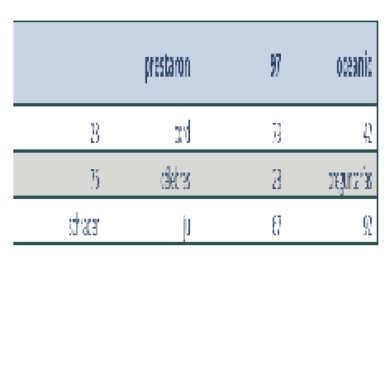

[0. 0. 0. 0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 23ms/step
[[0.1143573  0.04448364 0.07150547 0.05240152 0.12060726 0.37749097
  0.12269903 0.04565006 0.05080473]]
El valor máximo es: 0.37749096751213074
El índice de la columna con el valor máximo es: 5


In [20]:
for i,j in val:
    plt.imshow(i[0])
    plt.axis('Off')
    plt.show()
    print(j[0])
    pred= model.predict(img_array.reshape(-1,224,224,3))
    print(pred)
    max_index = np.argmax(pred[0],axis=-1)

    print(f"El valor máximo es: {max_value}")
    print(f"El índice de la columna con el valor máximo es: {max_index}")
    break
    